In [1]:
from glob import glob
import cv2
import numpy as np
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import tifffile as tf

from scipy import ndimage, signal
from skimage import morphology

import os
import pandas as pd

In [2]:
boundary = ndimage.generate_binary_structure(2,2).astype(int) - 2
boundary[1,1] = -(np.sum(boundary) + 1)

struc1 = ndimage.generate_binary_structure(2,1)
struc2 = ndimage.generate_binary_structure(2,2)


w = 5
its = 15
pad = its+10
fs = 20

mind = 50
buffx = 0
buffX = 1475
buffy = 200
erode = [None for i in range(5)]
coef = np.zeros((len(erode), 2))

tapes = np.zeros(len(erode), dtype=int)

src = '../raw/'
src = '/media/ejam/Elements/cuscuta/'
dst = '../raw/reference/'
imgsets = glob(src + '*')

metapos = np.zeros((len(imgsets), 2+6+5+2*5))
metarep = [None for i in range(len(imgsets))]
metatim = [None for i in range(len(imgsets))]

In [5]:
for i in range(len(metarep)):
    print(i, metatim[i], metarep[i], sep='\t')

0	4pm	5
1	12pm	1
2	12pm	2
3	12pm	3
4	12pm	4
5	12pm	5
6	12pm	6
7	4pm	1
8	4pm	2
9	4pm	3
10	4pm	4
11	4pm	6
12	4pm	7
13	9am	1
14	9am	2
15	9am	3
16	9am	4
17	9am	5
18	9am	6
19	9am	7


In [7]:
jdx = 6 # 4pm 1

foldername = os.path.split(imgsets[jdx])[1]
filenames = glob(imgsets[jdx] + '/*.JPG')

metatim[jdx],_,_,metarep[jdx] = foldername.split(' ')

nums = np.zeros(len(filenames), dtype=int) - 1
for i in range(len(nums)):
    num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('(')[1][:-1]
    num = int(num)
    nums[i] = num

nums = np.argsort(nums)

idx = 390
filename = filenames[nums[idx]]
numidx = int(os.path.splitext(os.path.split(filename)[1])[0].split('(')[1][:-1])
print(jdx, filename, numidx, sep='\t')
raw = cv2.imread(filename)
graw = raw[:,:,1]

xvals = np.arange(len(raw))
lines = np.zeros((len(coef), len(xvals)))    

medians = np.median(raw[:,:,0], axis=0)[300: ]
peaks, foo = signal.find_peaks(255 - medians, distance=300, height=140, prominence=50)
peaks += 300
if len(peaks) < 6:
    peaks = np.hstack((peaks, [raw.shape[1]]))
print('Peaks:\t', peaks)
stick = [np.s_[buffx:buffX+buffx, peaks[i]-buffy:peaks[i]+buffy] for i in range(len(erode))]

for i in range(len(stick)):
    foo = np.quantile(graw[buffx:, peaks[i]-w:peaks[i]+w], 0.75)
    print(i, foo, sep='\t')
    foo = np.min([90, foo])

    rmask = graw[stick[i]] < foo
    rmask = ndimage.median_filter(rmask, 11)
    rmask = np.pad(rmask, pad)

    bound = ndimage.convolve(rmask, boundary, mode='constant', cval=0)
    bound = ndimage.binary_dilation(bound, structure = struc2, iterations=its)

    fill = ndimage.binary_fill_holes(bound)
    erod = ndimage.binary_erosion(fill, structure = struc2, iterations=its//2, border_value=1)
    erode[i] = erod[pad:-pad, pad:-pad]

    tapes[i] = np.argmin(np.sum(erode[i][400:buffX], axis = 1)) + 400

    medial = np.zeros(len(erode[i]))    
    xmvals = np.arange(len(medial))
    for j in range(200, len(medial)):
        foo = np.nonzero(erode[i][j])[0]
        if len(foo) > 10:
            medial[j] = np.median(foo)

    mask = medial > 0
    coef[i] = P.polyfit(xmvals[mask], medial[mask], 1,full=False)

    b0 = peaks[i] + coef[i,0] - buffy
    lines[i] = b0 + coef[i,1]*(xvals - buffx)

print('Tapes:\t', tapes)

if plotting:

    fig, ax = plt.subplots(1,len(stick),figsize=(7,5), sharex=True, sharey=True, facecolor='tab:blue')
    ax = np.atleast_1d(ax).ravel()

    for i in range(len(stick)):

        ax[i].imshow(erode[i], vmin=0, cmap='Blues_r')
        ax[i].set_title(i, fontsize=fs, color='w')
        ax[i].axhline(tapes[i], c='yellow', lw=3, zorder=2)
        ax[i].axhline(400, c='magenta', zorder=1)
        ax[i].plot(lines[i, buffx:buffX+buffx] - peaks[i] + buffy, xvals[buffx:buffX+buffx] - buffx, c='r')

    fig.suptitle(foldername, fontsize=fs, color='w')
    fig.tight_layout();
    fname = dst + 'sticks_' + metatim[jdx] + '_' + metarep[jdx] + '.jpg'
    plt.savefig(fname, dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close();

    fig, ax = plt.subplots(1,1,figsize=(12,5), sharex=True, sharey=True)
    ax = np.atleast_1d(ax).ravel()
    ax[0].imshow(raw[:,:,::-1])
    for i in range(len(ax)):
        ax[i].axhline(buffX+buffx, c='magenta')
        ax[i].axhline(400+buffx, c='magenta')
        ax[i].axhline(buffx, c='blue')
        for j in range(len(coef)):
            ax[i].plot([lines[j,tapes[j]]-100, lines[j,tapes[j]]+100], [buffx+tapes[j], buffx+tapes[j]], c='yellow', lw=3)
            ax[i].plot(lines[j], xvals, c='red', lw=2)
            ax[i].axvline(peaks[j], c='limegreen', ls='--', lw=1)

    fig.suptitle(foldername, fontsize=fs, color='k')
    fname = dst + 'reference_' + metatim[jdx] + '_' + metarep[jdx] + '.jpg'
    plt.savefig(fname, dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
    plt.close();

metapos[jdx] = np.hstack((graw.shape, peaks, tapes, *coef.T))

6	/media/ejam/Elements/cuscuta/12pm Inc Rep 6/12pm Inc Rep 6 (391).JPG	391
Peaks:	 [ 667 1507 2390 3181 3993 4896]
0	48.0
1	48.0
2	76.0
3	53.0
4	46.0
Tapes:	 [1086 1166 1247 1243 1199]


0	/media/ejam/Elements/cuscuta/4pm Inc Rep 5/4pm Inc Rep 5 (1).JPG	1
Peaks:	 [ 581 1474 2254 3039 3948 4896]
0	48.0
1	45.0
2	50.0
3	51.0
4	57.0
Tapes:	 [1125 1245 1214 1171 1277]
1	/media/ejam/Elements/cuscuta/12pm Inc Rep 1/12pm Inc Rep 1 (1).JPG	1
Peaks:	 [ 770 1560 2420 2935 3742 4393]
0	105.0
1	151.0
2	131.0
3	74.0
4	71.0
Tapes:	 [745 718 716 864 732]
2	/media/ejam/Elements/cuscuta/12pm Inc Rep 2/12pm Inc Rep 2 (2).JPG	2
Peaks:	 [ 811 1457 2193 2766 3577 4321]
0	101.0
1	79.0
2	96.0
3	98.0
4	72.0
Tapes:	 [1151 1129 1147  914  905]
3	/media/ejam/Elements/cuscuta/12pm Inc Rep 3/12pm Inc Rep 3 (1).JPG	1
Peaks:	 [ 654 1469 2273 3076 3890 4896]
0	61.0
1	74.0
2	77.0
3	88.25
4	52.0
Tapes:	 [1111 1185 1268 1403 1359]
4	/media/ejam/Elements/cuscuta/12pm Inc Rep 4/12pm Inc Rep 4 (1).JPG	1
Peaks:	 [ 721 1530 2257 2945 3874 4896]
0	97.0
1	56.0
2	51.0
3	110.0
4	57.0
Tapes:	 [1011 1127 1022 1097 1113]
5	/media/ejam/Elements/cuscuta/12pm Inc Rep 5/12pm Inc Rep 5 (1).JPG	1
Peaks:	 [ 713 1558 2353 3

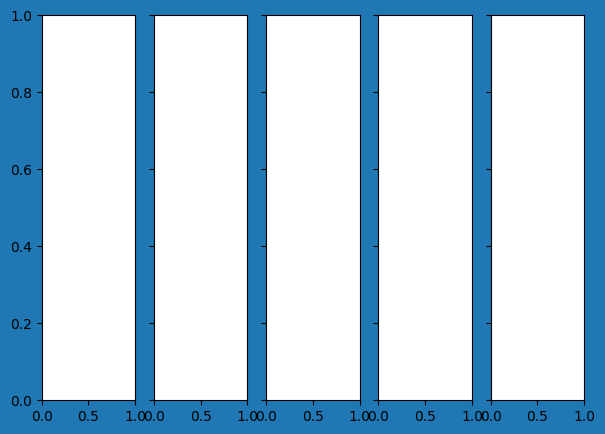

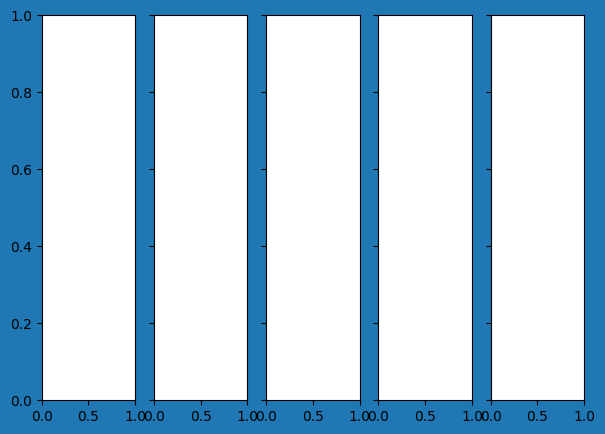

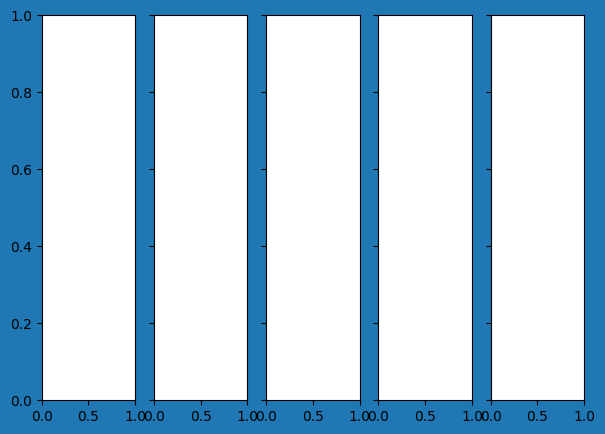

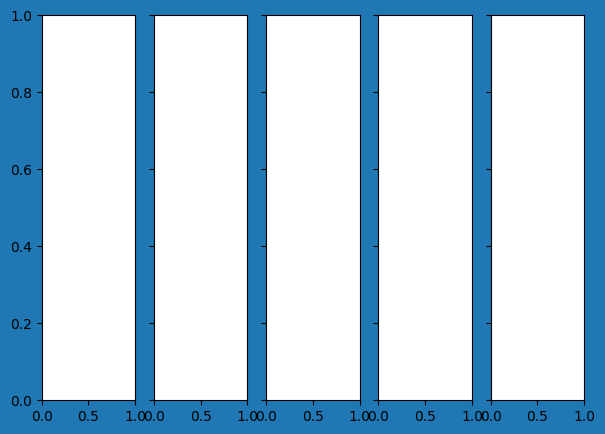

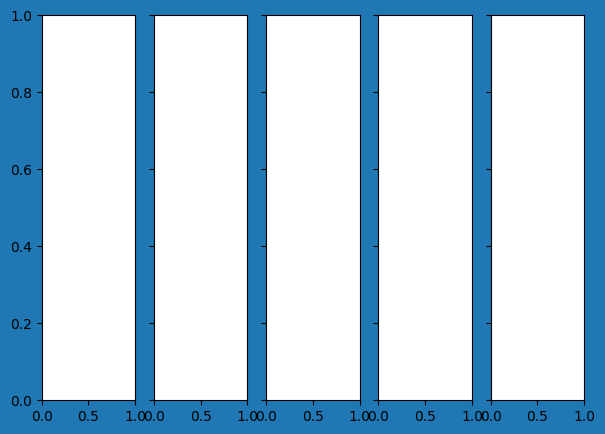

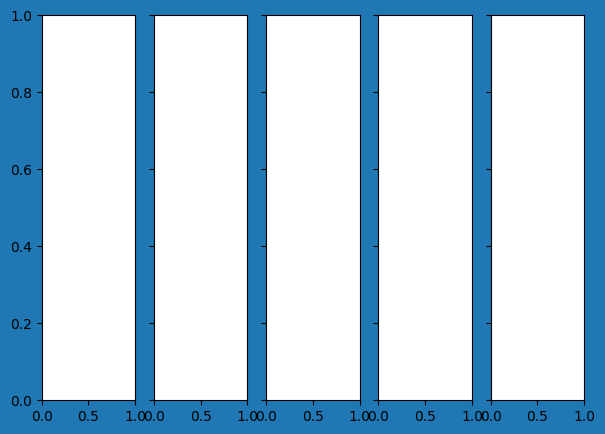

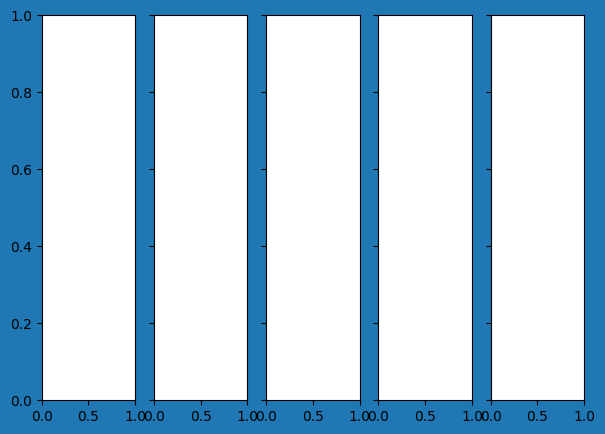

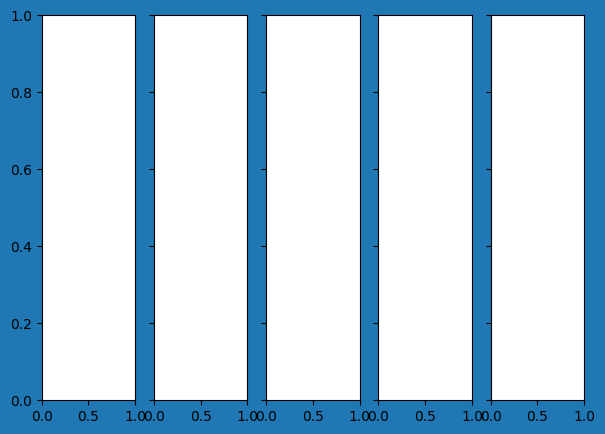

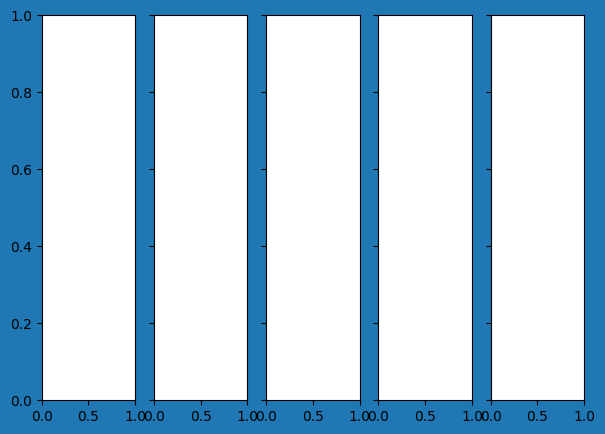

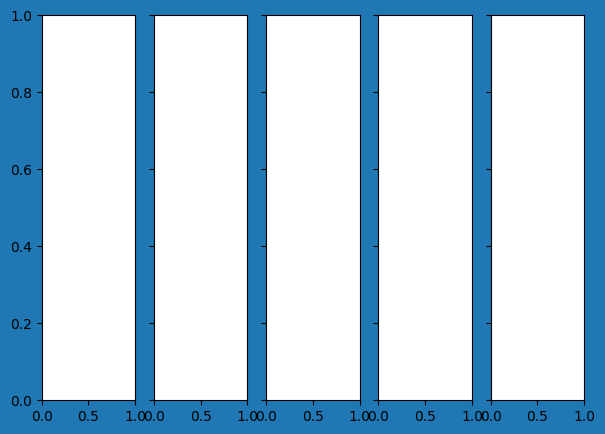

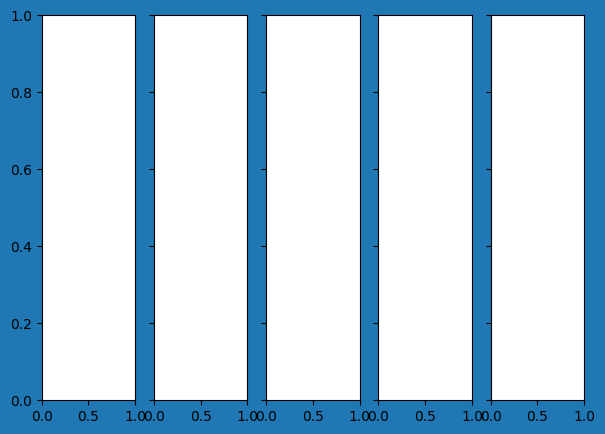

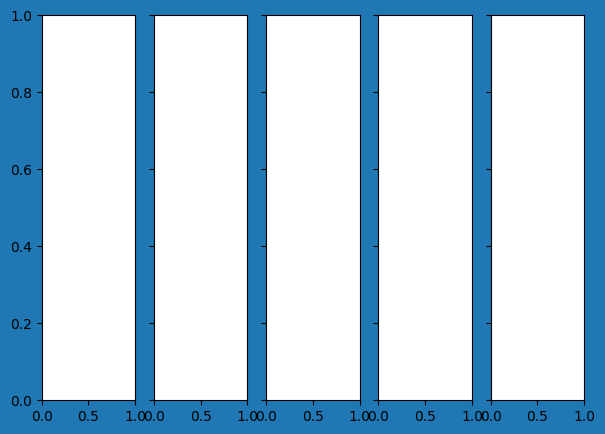

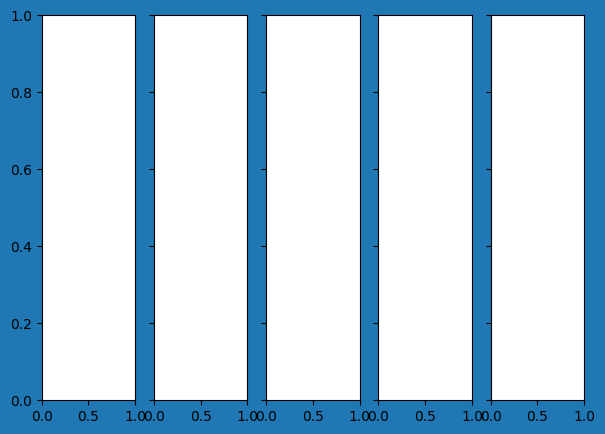

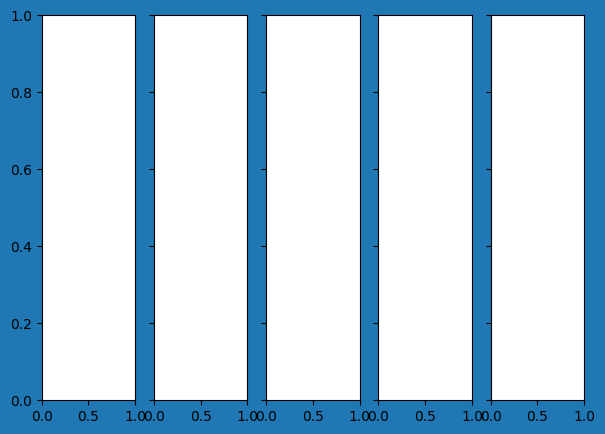

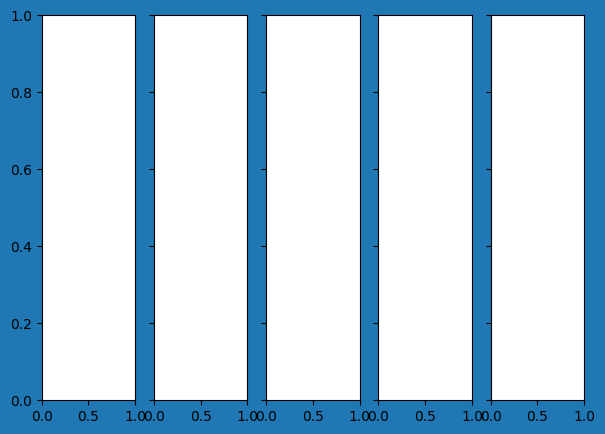

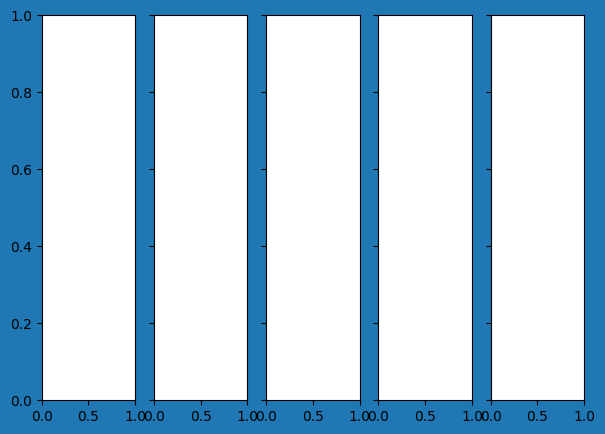

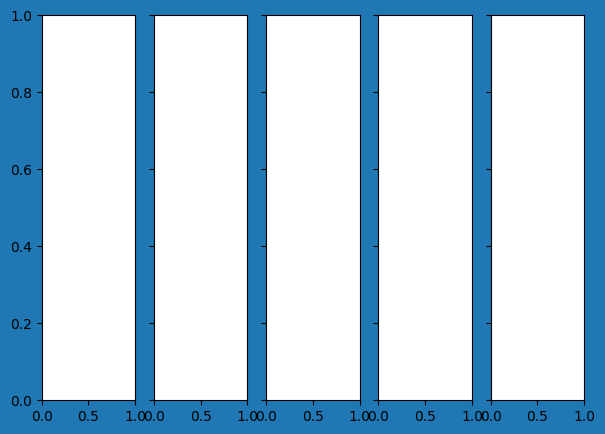

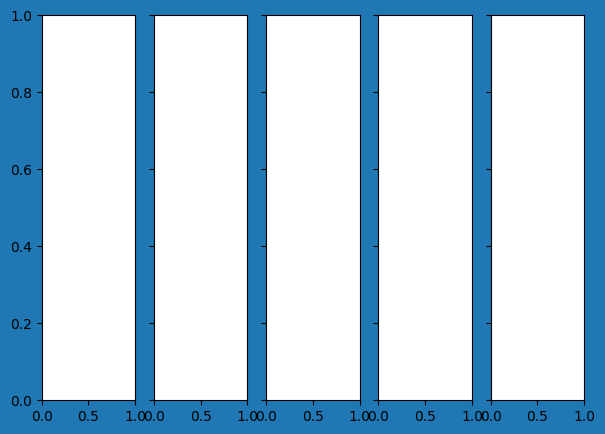

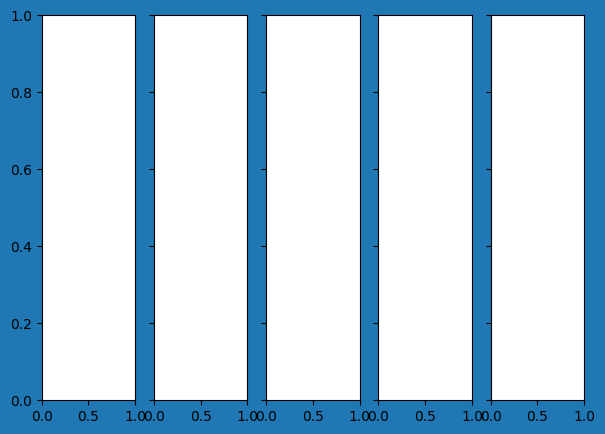

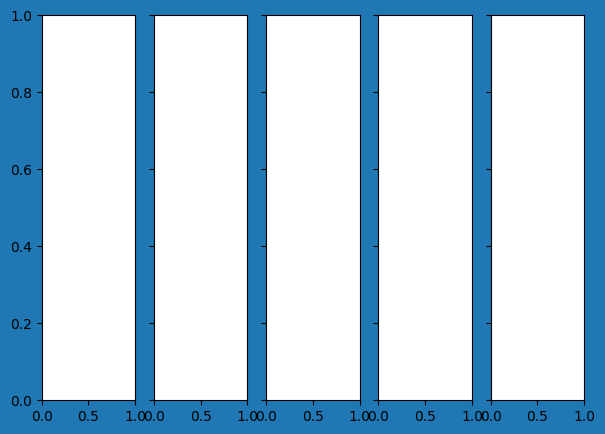

In [4]:
plotting = False
for jdx in range(len(imgsets)):
    foldername = os.path.split(imgsets[jdx])[1]
    filenames = glob(imgsets[jdx] + '/*.JPG')

    metatim[jdx],_,_,metarep[jdx] = foldername.split(' ')

    nums = np.zeros(len(filenames), dtype=int) - 1
    for i in range(len(nums)):
        num = os.path.splitext(os.path.split(filenames[i])[1])[0].split('(')[1][:-1]
        if num.isdigit():
            num = int(num)
            nums[i] = num
    nums = np.argsort(nums)

    idx = 0
    if nums[idx] != -1:
        filename = filenames[nums[idx]]
        numidx = int(os.path.splitext(os.path.split(filename)[1])[0].split('(')[1][:-1])
        print(jdx, filename, numidx, sep='\t')
        raw = cv2.imread(filename)
        graw = raw[:,:,1]

        xvals = np.arange(len(raw))
        lines = np.zeros((len(coef), len(xvals)))    

        medians = np.median(raw[:,:,0], axis=0)[300: ]
        peaks, foo = signal.find_peaks(255 - medians, distance=300, height=140, prominence=50)
        peaks += 300
        if len(peaks) < 6:
            peaks = np.hstack((peaks, [raw.shape[1]]))
        print('Peaks:\t', peaks)
        stick = [np.s_[buffx:buffX+buffx, peaks[i]-buffy:peaks[i]+buffy] for i in range(len(erode))]

        for i in range(len(stick)):
            foo = np.quantile(graw[buffx:, peaks[i]-w:peaks[i]+w], 0.75)
            print(i, foo, sep='\t')
            foo = np.min([90, foo])

            rmask = graw[stick[i]] < foo
            rmask = ndimage.median_filter(rmask, 11)
            rmask = np.pad(rmask, pad)

            bound = ndimage.convolve(rmask, boundary, mode='constant', cval=0)
            bound = ndimage.binary_dilation(bound, structure = struc2, iterations=its)

            fill = ndimage.binary_fill_holes(bound)
            erod = ndimage.binary_erosion(fill, structure = struc2, iterations=its//2, border_value=1)
            erode[i] = erod[pad:-pad, pad:-pad]

            tapes[i] = np.argmin(np.sum(erode[i][400:buffX], axis = 1)) + 400
            
            medial = np.zeros(len(erode[i]))    
            xmvals = np.arange(len(medial))
            for j in range(200, len(medial)):
                foo = np.nonzero(erode[i][j])[0]
                if len(foo) > 10:
                    medial[j] = np.median(foo)

            mask = medial > 0
            coef[i] = P.polyfit(xmvals[mask], medial[mask], 1,full=False)

            b0 = peaks[i] + coef[i,0] - buffy
            lines[i] = b0 + coef[i,1]*(xvals - buffx)

        print('Tapes:\t', tapes)

        fig, ax = plt.subplots(1,len(stick),figsize=(7,5), sharex=True, sharey=True, facecolor='tab:blue')
        ax = np.atleast_1d(ax).ravel()
        
        if plotting:
            for i in range(len(stick)):

                ax[i].imshow(erode[i], vmin=0, cmap='Blues_r')
                ax[i].set_title(i, fontsize=fs, color='w')
                ax[i].axhline(tapes[i], c='yellow', lw=3, zorder=2)
                ax[i].axhline(400, c='magenta', zorder=1)
                ax[i].plot(lines[i, buffx:buffX+buffx] - peaks[i] + buffy, xvals[buffx:buffX+buffx] - buffx, c='r')

            fig.suptitle(foldername, fontsize=fs, color='w')
            fig.tight_layout();
            fname = dst + 'sticks_' + metatim[jdx] + '_' + metarep[jdx] + '.jpg'
            plt.savefig(fname, dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
            plt.close();

            fig, ax = plt.subplots(1,1,figsize=(12,5), sharex=True, sharey=True)
            ax = np.atleast_1d(ax).ravel()
            ax[0].imshow(raw[:,:,::-1])
            for i in range(len(ax)):
                ax[i].axhline(buffX+buffx, c='magenta')
                ax[i].axhline(400+buffx, c='magenta')
                ax[i].axhline(buffx, c='blue')
                for j in range(len(coef)):
                    ax[i].plot([lines[j,tapes[j]]-100, lines[j,tapes[j]]+100], [buffx+tapes[j], buffx+tapes[j]], c='yellow', lw=3)
                    ax[i].plot(lines[j], xvals, c='red', lw=2)
                    ax[i].axvline(peaks[j], c='limegreen', ls='--', lw=1)

            fig.suptitle(foldername, fontsize=fs, color='k')
            fname = dst + 'reference_' + metatim[jdx] + '_' + metarep[jdx] + '.jpg'
            plt.savefig(fname, dpi=150, format='jpg', bbox_inches='tight', pil_kwargs={'optimize':True})
            plt.close();

        metapos[jdx] = np.hstack((graw.shape, peaks, tapes, *coef.T))

# Wrangle metadata

In [8]:
#metapos[jdx] = np.hstack((graw.shape, peaks, tapes, *coef.T))

meta = pd.DataFrame()
meta['id'] = [metatim[i] + '_' + metarep[i] for i in range(len(metatim))]
meta['time'] = metatim
meta['repetition'] = np.asarray(metarep).astype(np.uint8)

j = 0
for i in range(graw.ndim):
    foo = 'raw_shape_{}'.format(i)
    meta[foo] = metapos[:,j].astype(int)
    j += 1

for i in range(len(peaks)):
    foo = 'peaks_{}'.format(i)
    meta[foo] = metapos[:,j].astype(int)
    j += 1
    
for i in range(len(tapes)):
    foo = 'tapes_{}'.format(i)
    meta[foo] = metapos[:, j].astype(int)
    j += 1
    
for i in range(len(tapes)):
    foo = 'coef0_{}'.format(i)
    meta[foo] = metapos[:, j]
    j += 1
    
for i in range(len(tapes)):
    foo = 'coef1_{}'.format(i)
    meta[foo] = metapos[:, j]
    j += 1

In [9]:
fname = '../raw/reference_positions.csv'
meta.to_csv(fname, index=False)